In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import sympy as sp

import functions as fnc

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}

In [3]:
Feld3D = np.transpose(np.genfromtxt("B-Field [Ms]_NEW.txt", skip_header = 2))

In [4]:
# -------------- ERSTELLEN DER WERTE --------------

array = np.array([np.zeros(601).tolist() for i in range(10)]) # erschaffe array mit 10 Spalten und je 601 Einträgen 
# darin sind je 100er blöcke von gleichen Ausgangssituationen 

array[0][1:101]   = np.linspace(-5e-3, 5e-3, 100)  # Vektor hat erste   100 Werte: x von -5 bis 5 mm
array[3][101:201] = np.linspace(-5e3, 5e3, 100)    # Vektor hat zweite  100 Werte: px von -5 bis 5 keV/c
array[1][201:301] = np.linspace(-1e-3, 1e-3, 100)   # 100 Werte: y von -1 bis 1 mm
array[4][301:401] = np.linspace(-1e3, 1e3, 100)     # 100 Werte: py von -1 bis 1 keV/c
array[2][401:501] = np.linspace(-3e-3, 3e-3, 100)   # 100 Werte: z von -3 bis 3 mm
array[5][501:601] = np.linspace(-3e3, 3e3, 100)     # 100 Werte: pz von -3 bis 3 keV/c

# Lege Energie des Referenzparticless fest
prefi = np.transpose(array)[0][5] = 6e6 #6 MeV/c

# Die Relativkoordinaten zur Beschreibung der particles 
# so verstehe ich gerade die Beschreibung im Buch. x, y, z sind relativ zum particles.
# Dann bewegt sich aber ständig auch ein Winkel mit. Das kann doch nicht richtig sein?

# Seite 119 im Hinterberger. 
# Daher muss ich dann bei den finalen Werten das System drehen - oder?


xi = array[0].copy()  # x, y und z sind immer relativ zum particles beschrieben.
yi = array[1].copy()
zi = array[2].copy() 
zi[1:601] = zi[1:601] + zi[0]   # z Werte waren ja nur relativ zu zRef angegeben. Brauche die natürlich in meinem Bezugssystem!

pxi = array[3].copy()
pyi = array[4].copy()
pzi = array[5].copy()
pzi[1:601] = pzi[1:601] + pzi[0]

#Lege für Astra noch die anderen Spalten fest:
array[-1] = 5 #alle kriegen Status Flag 5
for i in range(6):
    array[-1][i*100 + 1] = 3 # das erste particles jeder Art kriegt ne 3
    
array[-2] = 1 #Particle
array[-3] = 1e-7 #10^-7 nC Charge 


Array = np.transpose(array)
np.savetxt("Dipole.ini", Array)  # speichere direkt, dass nur noch Astra auszuführen ist

In [6]:
BmaxASTRA = 6.0179E-02
BmaxRechnung = 5.17069438e-02

k = BmaxASTRA/BmaxRechnung
k

BmaxRechnung*k
k

1.1638475527149605

In [7]:
# import all x, y, z, By Feld3D and transpose so that they are distributed around the center of the grid
xAlle = Feld3D[0] - max(Feld3D[0]) + (max(Feld3D[0])-min(Feld3D[0]))/2 # long side
yAlle = Feld3D[1] - max(Feld3D[1]) + (max(Feld3D[1])-min(Feld3D[1]))/2 #
zAlle = Feld3D[2] - max(Feld3D[2]) + (max(Feld3D[2])-min(Feld3D[2]))/2 # short side


z_Stepwidth = np.where(zAlle != zAlle[0])[0][0] #stepwidth
Schrittweitez = zAlle[z_Stepwidth]-zAlle[0]

#k = -1.1638475527149605 #taken from ASTRA
k = -1.0883
ByAlle = Feld3D[4] * k   #T for scaling - so that this field here

print(max(abs(ByAlle)))

# all indices at which x restarts (for grid) 
xRestarts = np.where(xAlle == xAlle[0])
zChanges = []
zSpannweite = max(zAlle) - min(zAlle) # unterschied zwischen kleinstem und größtem z


# zChanges gives indices at which z changes. After that: take first 400 (Nx) values since x changes
for n in range(int(zSpannweite / Schrittweitez)):
    zChanges.append(np.where(zAlle == zAlle[0] + Schrittweitez * (n+1))[0][0])
zChanges = np.concatenate(([0], np.array(zChanges)))

print(Schrittweitez)

0.0601827277197
1.0


Alle 36 xRestarts Werte beginnt ein neues z. Dann brauche ich also nur von jedem xRestarts Wert diesen und die folgenden 400, dann habe ich alle x, z Paare

In [8]:
Tracking = np.transpose(np.genfromtxt("Dipole.track.001"))
Tracking[2] *= 1000 # mm #z

Tracking[3] *= -1 #x
# notice orientation 

# rotate trajectories from ASTRA
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

rot = rotate(np.array([Tracking[2][0], Tracking[3][0]]), np.array([Tracking[2], Tracking[3]]), 30 * np.pi / 180)
Tracking[3]   = rot[1] #x
Tracking[2]   = rot[0] #z

# add offset, so that everything is located correctly
Tracking[3] -= Tracking[3][0]
Tracking[2] -= Tracking[2][0] 

particlesTracked = int(Tracking[0][0])

xList = [[] for i in range(particlesTracked)]
yList = [[] for i in range(particlesTracked)]
zList = [[] for i in range(particlesTracked)]

for n in range(particlesTracked):
    for i in range(int(len(Tracking[2]) / particlesTracked)):
        # Create lists with tracked x and z for every tracked particle
        xList[n].append(Tracking[3][i*particlesTracked+particlesTracked-1-n])
        yList[n].append(Tracking[4][i*particlesTracked+particlesTracked-1-n])
        zList[n].append(Tracking[2][i*particlesTracked+particlesTracked-1-n])
        

# nutze nur die Daten, die im Bereich liegen, wo ich auch ein B-Feld kenne
#start = np.where(np.array(z1) >1479)[0][0]
#ende = np.where(np.array(z1) >2152)[0][0]

#for i in range(int(Tracking[0][0])):
#    zList[i] = zList[i][start:ende]
#    xList[i] = xList[i][start:ende]

  
T = [[] for i in range(particlesTracked)] 

for n in range(particlesTracked):
    # gives list with all trajectories
    T[n] = np.array([zList[n], xList[n], yList[n]])
    

In [9]:
By = []
x = []
y = []
z = []
yOffset = np.where(yAlle == 0)[0][0]

for i in range(len(zChanges)):
    for k in range(xRestarts[0][1]):
        Wert = zChanges[i] + k +  yOffset #das ist plus den Wert wo y = 0 ist
        By.append(ByAlle[Wert])
        x.append(xAlle[Wert])
        y.append(yAlle[Wert])
        z.append(zAlle[Wert])
      
    
#HIER MUSS ICH DAFÜR SORGEN DASS NICHT DIE ERSTEN 400 WERTE GENOMMEN WERDEN, SONDERN DIE BEI DENEN Y=0 IST
By = np.array(By) # By values from first fourhundred x changes for every z

x = np.array(x)
y = np.array(y)
z = np.array(z)
By = By.reshape((len(zChanges), xRestarts[0][1]))

#
xWerte = x[:xRestarts[0][1]]
zWerte = []
for i in range(int(len(x) / xRestarts[0][1])):
    zWerte.append(z[i * xRestarts[0][1]])
zWerte = np.asarray(zWerte)
 

# Wo ist der Start wenn ich aus Mitte raus gucke

zOffsetMesh = 1664
xOffsetMesh = 866.5

xWerte += zOffsetMesh
zWerte += xOffsetMesh
    
Z, X = np.meshgrid(xWerte, zWerte)

By = By * 1000#mT


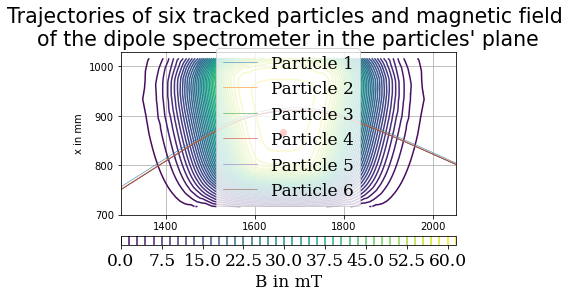

In [10]:
CS = plt.contour(Z, X, By, 50)
plt.rc('font', **font)
plt.clabel(CS, inline = False, fontsize=0, inline_spacing  = 10)
plt.title("Trajectories of six tracked particles and magnetic field \nof the dipole spectrometer in the particles' plane")
plt.xlabel("z in mm")
plt.ylabel("x in mm")


cbar = plt.colorbar(orientation = "horizontal", aspect = 40, pad=0.1)
cbar.set_label('B in mT')

plt.rcParams['figure.figsize'] = [14, 9]



# plotte für alle particles im nicht rotierten System, in dem ich das BFeld kenne 

for n in range(particlesTracked):
    plt.plot(T[n][0], T[n][1], label = f"Particle {n+1}", linewidth = .5)

plt.plot(zOffsetMesh, xOffsetMesh, "ro")
plt.xlim(1300, 2050)
plt.ylim(700, 1030)
plt.legend()
plt.grid()
plt.savefig(f'3DField.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

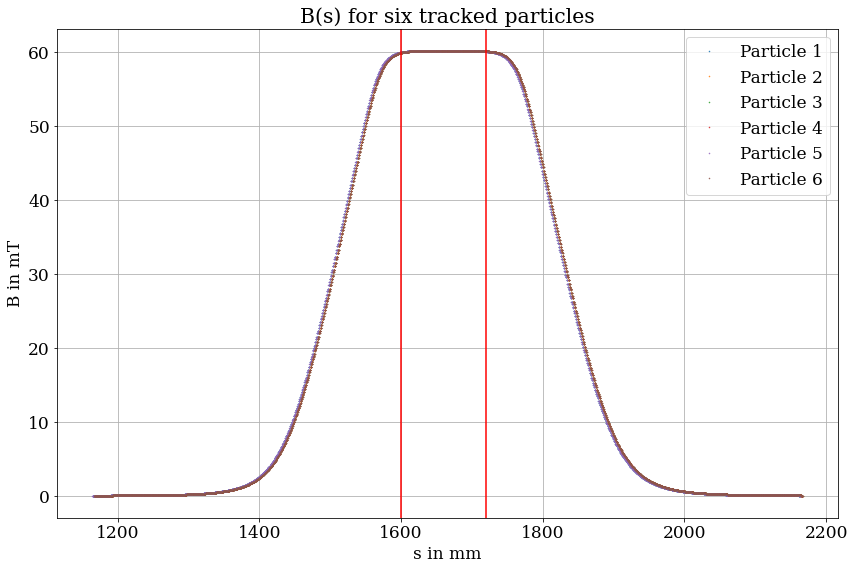

In [11]:
zGrid = Z[0] # alle z Daten
xGrid = np.transpose(X)[0] # alle x Daten

# damit ich auch auf die ZListImGrid zugreifen kann . hier alle z die durch die particles getrackt sind und am nächsten liegen
zListImGrid = [[] for i in range(particlesTracked)]

def find_nearest(array, value):
    """
    gibt mir den Wert aus array zurück, welcher am nächsten an value dran ist 
    gibt auch den Index dieses Wertes in array zurück
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return [array[idx], idx]

# fülle alle Unterlisten - je nach dem wie viele particles ich tracke
nearestZ = [[] for i in range(particlesTracked)]
nearestX = [[] for i in range(particlesTracked)]
indexZ = [[] for i in range(particlesTracked)]
indexX = [[] for i in range(particlesTracked)]

ByAllParticles = [[] for i in range(int(Tracking[0][0]))]

for n in range(particlesTracked):
    
    for z in range(len(T[n][0])):
        nearestZ[n].append(find_nearest(zGrid, T[n][0][z])[0]) #gibt den nächsten Wert an, der in zGrid zu finden ist zu diesem Trajektorienwert
        nearestX[n].append(find_nearest(xGrid, T[n][1][z])[0]) # givt nächsten x Wert aus Grid an zu Tx
        indexZ[n].append(find_nearest(zGrid, T[n][0][z])[1]) # gibt Index an, wo dieser Wert aus zGrid zu finden ist
        indexX[n].append(find_nearest(xGrid, T[n][1][z])[1]) 

    firstZ = np.where(nearestZ[0] != nearestZ[0][0])[0][0] # gibt die Stelle, an der das näcghste z nicht mehr das erste z ist == die Stelle, wo wir uns in das Grid hinein bewegen
    lastZ = np.where(nearestZ[0] == nearestZ[0][-1])[0][0] # gibt die Stelle, an der das erste z das gleiche ist wie alle kommenden == wo wir aus dem Grid rausgehen 

    zImGrid = T[n][0][firstZ-1:lastZ] # alle zTn Werte, die im Grid liegen 
    xImGrid = T[n][1][firstZ-1:lastZ]
    zIndizesGrid = indexZ[0][firstZ-1:lastZ] # gibt die jeweiligen Indizes an
    xIndizesGrid = indexX[0][firstZ-1:lastZ]

    B = [] # Liste mit B Werten - genausolang wie die Liste mit zWerten im Grid 
    for k in range(len(zIndizesGrid)):
        B.append(By[xIndizesGrid[k]][zIndizesGrid[k]])
        ByAllParticles[n].append(By[xIndizesGrid[k]][zIndizesGrid[k]])
        
    zListImGrid[n].append(T[n][0][firstZ-1:lastZ])
    plt.plot(zImGrid, B, ".", markersize = 1, label = f"Particle {n+1}") #plotte B über z

plt.rcParams['figure.figsize'] = [14, 5]    
plt.grid()
plt.xlabel("s in mm")
plt.ylabel("B in mT")
plt.title("B(s) for six tracked particles")
plt.legend()

# start of the plateau
PStart = 1600
PEnd = 1720

plt.axvline(x=PStart, color = "r")
plt.axvline(x=PEnd, color = "r")
plt.savefig(f'BOnTrajectory.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

Kann nun die effektive Länge des Magneten berechnen:

\begin{align}
\frac{1}{B_0} \int _{-\infty}^{\infty} B(s)d s
\end{align}

In [12]:
start = np.where(zImGrid >= PStart)[0][0] # 1600 < z < 1730
ende = np.where(zImGrid >= PEnd)[0][0]

Bmax = []
BmaxU = []

# Berechne Maximum B Wert - Mittelwert
for n in range(particlesTracked):
    Bmax.append(np.mean(ByAllParticles[n][start:ende]) )
    BmaxU.append(np.std(ByAllParticles[n][start:ende]) )

Bmax = np.mean(Bmax)
uBmax = np.mean(BmaxU)
uB = 0
n =1
print(Bmax)
le = []
ule = []
for n in range(6):
    
    Leff = np.trapz(np.asarray(ByAllParticles[n]), zImGrid) / (Bmax)  # Integral über alle Messpunkte
    uLeff = np.sqrt((-Bmax**(-2) * np.trapz(np.asarray(ByAllParticles[n]), zImGrid) * uBmax)**2 + np.sum(np.array(Bmax**(-1) * np.asarray(ByAllParticles[n]) * uB)**2))
    le.append(Leff)
    ule.append(uLeff)
print(f"Integriert ergibt die effektive Länge: Leff = ({fnc.roundingDIN(Leff, uLeff)[0]} +- {fnc.roundingDIN(Leff, uLeff)[1]}) mm \n (Bmax gemittelt am Plateau)\n") # in mm


BmaxAll = max(ByAllParticles[n])
uBmaxAll = max(BmaxU)
LeffAll = np.trapz(np.asarray(ByAllParticles[n]), zImGrid) / (BmaxAll)  # Integral über alle Messpunkte
uLeffAll = np.sqrt((-BmaxAll**(-2) * np.trapz(np.asarray(ByAllParticles[n]), zImGrid) * uBmaxAll)**2 + np.sum(np.array(BmaxAll**(-1) * np.asarray(ByAllParticles[n]) * uB)**2))
print(f"Integriert ergibt die effektive Länge: Leff = ({fnc.roundingDIN(LeffAll, uLeffAll)[0]} +- {fnc.roundingDIN(LeffAll, uLeffAll)[1]}) mm \n (Bmax als max(B))\n") # in mm
[Leff,uLeff]
[Bmax, uBmax]

60.152488183969446
Integriert ergibt die effektive Länge: Leff = (342.14 +- 0.29000000000000004) mm 
 (Bmax gemittelt am Plateau)

Integriert ergibt die effektive Länge: Leff = (341.97 +- 0.29000000000000004) mm 
 (Bmax als max(B))



[60.152488183969446, 0.0508757699945231]

In [13]:
e = -1.602176634 * 10 **(-19)# C
m = 0.51099895000 / 10**6

# this is p apparently. (Hinterberger p. 120) but I think it should be EKin

def EKin(p):
    """Rechnet Impuls in Energie um"""
    m0 = 0.51099895000 # MeV/c
    c = 299792458
    
    Ekin = m0 * (np.sqrt(1 + (p/(m0))**2) - 1)
    
    return Ekin

def pfct(Ekin):
    """Rechnet Energie in Impuls um"""
    m0 = 0.51099895000 # MeV/c
    c = 299792458
    
    p = np.sqrt((Ekin/m0 + 1)**2-1) * m0
    
    return p


p = 299.792458 * (Bmax / 1000) * (Leff / 1000) / np.sin(60 * np.pi/180) #/ (1.602176634 * 10 **(-19) / (2.88 * 10**(8))) / 10**6
e = -1.602176634 * 10 **(-19)# C
m = 0.51099895000 / 10**6

print("")
#print("ACHTUNG: NEHME HIER JETZT DAS KLEINERE LEFF, HIERMIT KLAPPT ES NÄMLICH")
print("Also muss der Impuls eines Teilchens sein: ")
p = (299.792458 * ((Bmax) / 1000) * ((Leff/ 1000) / (np.sin(60 * np.pi/180))))
up = np.sqrt((299.792458 * (Leff/ 1000) / np.sin(60/180*np.pi) * (uB/ 1000))**2+(299.792458 * (Bmax / 1000) / np.sin(60/180*np.pi) * (uLeff/ 1000))**2)
print("Mit Bmax aus der Mitte:\np= (", fnc.roundingDIN(p, up)[0], "+-", fnc.roundingDIN(p, up)[1], ") MeV/c")
print("B = (", fnc.roundingDIN(Bmax, uBmax)[0], "+-", fnc.roundingDIN(Bmax, uBmax)[1], ") mT")
print("Leff = ", Leff, "mm")


print("")
p = (299.792458 * ((max(B)) / 1000) * ((LeffAll / 1000) / (np.sin(60 * np.pi/180))))
up = np.sqrt((299.792458 * (LeffAll/ 1000) / np.sin(60/180*np.pi) * (uB/ 1000))**2+(299.792458 * (max(B) / 1000) / np.sin(60/180*np.pi) * (uLeffAll/ 1000))**2)


print("Mit Bmax = max(B):\np= (", fnc.roundingDIN(p, up)[0], "+-", fnc.roundingDIN(p, up)[1], ") MeV/c")
print("B = (", fnc.roundingDIN(max(B), uBmax)[0], "+-", fnc.roundingDIN(max(B), uBmax)[1], ") mT")
print("Leff = ", LeffAll, "mm")



Also muss der Impuls eines Teilchens sein: 
Mit Bmax aus der Mitte:
p= ( 7.124 +- 0.007 ) MeV/c
B = ( 60.15 +- 0.06 ) mT
Leff =  342.13606323536976 mm

Mit Bmax = max(B):
p= ( 7.124 +- 0.007 ) MeV/c
B = ( 60.18 +- 0.06 ) mT
Leff =  341.9660884022858 mm


In [14]:
0.91597 * 0.88

0.8060535999999999

## Problem:

wenn ich den Test mache, und 

$
p_0 [\textrm{MeV/c}] = 299.792458 \cdot  \frac{L_{\mathrm{eff}} [\mathrm{m}] }{\sin 60 \mathrm{°}} \cdot  B_0 [\mathrm{T}]$

einsetzte, dann kommt mit der angegebenen effektiven Länge und maximalen B Feld stärke nie die 6MeV/c Impulse heraus, die ich erwarten würde. 
### nicht mal ansatzweise!
Es klappt nur, wenn ich einmal die kleinere effektive Länge nutze, aber das macht nicht so richtig viel sinn. Die effektive Länge sollte ich schon mit dem B Feld auf dem Plateau berechnne.


Ihc kriege ungefähr 4keV zu viel Impuls. Und das ist ziemlich sicher wirklich der Impuls, nicht die Energie.


## Problem:
kenne Unsicherheit von B nicht (CST)

Nehme die Randeffekte heraus

## Gleiches Problem: Teilchen ist immer noch mit zu viel Energie unterwegs.

Hiermit klappt es also gar nicht. Null.


In [ ]:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(zOffsetMesh, xOffsetMesh, "ro")
plt.xlim(1100, 2200)
plt.ylim(650, 1030)


for n in range(particlesTracked):
    ax1.plot(T[n][0], T[n][1], label = f"T{n+1}", linewidth = .5)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, 50)
    ax1.set_title("Anfang")
    ax1.legend()
    ax1.grid()
    
for n in range(particlesTracked):
    ax2.plot(T[n][0], T[n][1], label = f"T{n+1}", linewidth = .5)
    ax2.set_xlim(1500, 1600)
    ax2.set_ylim(800, 900)
    ax2.set_title("Mitte")
    ax2.legend()
    ax2.grid() 
    
    
for n in range(particlesTracked):
    ax3.plot(T[n][0], T[n][1], label = f"T{n+1}", linewidth = .5)
    ax3.set_xlim(2000, 2200)
    ax3.set_ylim(650, 775)
    ax3.set_title("Fokus")
    ax3.legend()
    ax3.grid()  
    
    
for n in range(particlesTracked):
    ax4.plot(T[n][0], T[n][1], label = f"T{n+1}", linewidth = .5)
    ax4.set_xlim(2200, 2220)
    ax4.set_ylim(640, 650)
    ax4.set_title("Ende")
    ax4.legend()
    ax4.grid()
    
plt.legend()

plt.show()

In [ ]:
Tracking = np.transpose(np.genfromtxt("Dipole.track.001"))
Tracking[2] *= 1000 # mm


xList = [[] for i in range(particlesTracked)]
zList = [[] for i in range(particlesTracked)]

for n in range(particlesTracked):
    for i in range(int(len(Tracking[2]) / particlesTracked)):
        # Erstelle hiermit die Listen mit den getrackten x und z Positionen für jedes getrackte particles
        xList[n].append(Tracking[3][i*particlesTracked+particlesTracked-1-n])
        zList[n].append(Tracking[2][i*particlesTracked+particlesTracked-1-n])


ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)


plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(zOffsetMesh, xOffsetMesh, "ro")
plt.title("Festes Koordinatensystem, Ursprung ist Elektronenbunch am Anfang")

for n in range(len(xList)):
    ax1.set_xlabel("z in mm")
    ax1.set_ylabel("x in mm")
    ax1.plot(zList[n], xList[n], ".", markersize = .5, label = f"T{n+1}")
    ax1.set_xlim(0, 100)
    ax1.set_ylim(-10, 50)
    ax1.set_title("Anfang")
    ax1.legend()
    ax1.grid()
    
    ax2.set_xlabel("z in mm")
    ax2.set_ylabel("x in mm")
    ax2.plot(zList[n], xList[n], ".", markersize = .5, label = f"T{n+1}")
    ax2.set_xlim(1700, 1900)
    ax2.set_ylim(-10, 200)
    ax2.set_title("Anfang Magnet")
    ax2.legend()
    ax2.grid() 
    
    ax3.set_xlabel("z in mm")
    ax3.set_ylabel("x in mm")
    ax3.plot(zList[n], xList[n], ".", markersize = .5, label = f"T{n+1}")
    ax3.set_xlim(2025, 2175)
    ax3.set_ylim(200, 400)
    ax3.set_title("Fokus oben rechts")
    ax3.legend()
    ax3.grid()  

    ax4.set_xlabel("z in mm")
    ax4.set_ylabel("x in mm")
    ax4.plot(zList[n], xList[n], ".", markersize = 2, label = f"T{n+1}")
    ax4.set_xlim(2160, 2200)
    ax4.set_ylim(400, 500)
    ax4.set_title("Zoom auf Fokus")
    ax4.legend()
    ax4.grid()
    
    ax5.set_xlabel("z in mm")
    ax5.set_ylabel("x in mm")
    ax5.plot(zList[n], xList[n], ".", markersize = 5, label = f"T{n+1}")
    ax5.set_xlim(2230, 2250)
    ax5.set_ylim(530, 570)
    ax5.set_title("Zoom auf Fokus")
    ax5.legend()
    ax5.grid()
    
    ax6.set_xlabel("z in mm")
    ax6.set_ylabel("x in mm")
    ax6.plot(zList[n], xList[n], ".", markersize = .5, label = f"T{n+1}")
    ax6.set_xlim(2200, 2400)
    ax6.set_ylim(500, 830)
    ax6.set_title("Ende")
    ax6.legend()
    ax6.grid()

plt.legend()